In [1]:
import torch
import torch.nn as nn
from dataset import get_transforms, CT_Dataset
from models import UNet
import os
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import random
import monai
from tqdm import tqdm
import pandas as pd

In [2]:
csv_dir = "/home/anees.hashmi/Desktop/labs/hc701_assignment_3/csv_liver_only"
model_dir = "/home/anees.hashmi/Desktop/labs/hc701_assignment_3/models"
device = "cuda"
num_workers = 24
batch_size = 1
num_classes = 2
model_path ="/home/anees.hashmi/Desktop/labs/hc701_assignment_3/models/"
result_dir ="./results/"
backbone = "mobilenet_v2"
model_name = "unet_dice_loss_mobilenet_v2_1.0_1.0"

all_model_names = ['unet_dice_loss_mobilenet_v2_1.0_1.0', 'unet_dice_loss_mobilenet_v2_1.0_5.0', 
                   'unet_BCE_loss_mobilenet_v2_1.0_5.0', 'unet_dice_loss_resnet101_1.0_5.0', 
                   'unet_dicebce_loss_mobilenet_v2_1.0_5.0']
backbones= {'mobilenet':"mobilenet_v2", "resnet101":"resnet101"}

checkpoint = None

if not checkpoint:
    all_chckpoints = [i[:-4] for i in sorted(os.listdir(f"{model_path}{model_name}"))]
    checkpoint = f"""{["_".join(i) for i in sorted([i.split('_') for i in all_chckpoints], key=lambda x: int(x[-4]))][-1]}.pth"""


In [3]:
def init_test(model, test_loader, device, model_name):
    sig = nn.Sigmoid()
    with torch.no_grad():
        test_dice_score = 0
        test_dice_score_cls1 = 0
        test_dice_score_cls2 = 0
        
        test_jaccard_score = 0
        test_jaccard_score_cls1 = 0
        test_jaccard_score_cls2 = 0

        test_accuracy = 0
        test_accuracy_cls1 = 0
        test_accuracy_cls2 = 0

        for images, true_masks in tqdm(test_loader):
            images = images.to(device)
            true_masks = true_masks.to(device)

            pred_masks = sig(model(images)).round()
            
            pred_cls1= pred_masks[:, 0, :, :]
            pred_cls2 = pred_masks[:, 1, :, :]

            true_cls1 = true_masks[:, 0, :, :]
            true_cls2 = true_masks[:, 1, :, :]                
            
            test_dice_score += monai.metrics.compute_dice(pred_masks, true_masks, include_background=False, ignore_empty=False).mean() # mean dice score
            test_dice_score_cls1 += monai.metrics.compute_dice(pred_cls1.reshape(pred_cls1.shape[0], 1, 256, 256), true_cls1.reshape(true_cls1.shape[0], 1, 256, 256), include_background=False, ignore_empty=False).mean().item() 
            test_dice_score_cls2 += monai.metrics.compute_dice(pred_cls2.reshape(pred_cls1.shape[0], 1, 256, 256), true_cls2.reshape(true_cls1.shape[0], 1, 256, 256), include_background=False, ignore_empty=False).mean().item()

            test_jaccard_score += monai.metrics.compute_iou(pred_masks, true_masks, include_background=False, ignore_empty=False).mean() # mean jaccard score            
            test_jaccard_score_cls1 += monai.metrics.compute_iou(pred_cls1.reshape(pred_cls1.shape[0], 1, 256, 256), true_cls1.reshape(true_cls1.shape[0], 1, 256, 256), include_background=False, ignore_empty=False).mean().item()
            test_jaccard_score_cls2 += monai.metrics.compute_iou(pred_cls2.reshape(pred_cls1.shape[0], 1, 256, 256), true_cls2.reshape(true_cls1.shape[0], 1, 256, 256), include_background=False, ignore_empty=False).mean().item()

            test_accuracy +=(pred_masks == true_masks).sum()/pred_masks.numel()
            test_accuracy_cls1 += (pred_cls1 == true_cls1).sum()/pred_cls1.numel()
            test_accuracy_cls2 += (pred_cls2 == true_cls2).sum()/pred_cls2.numel()

        df_dict = {'model_name': [model_name], 
                    'Dice Score': [test_dice_score.cpu().numpy()/len(test_loader)], 
                    'Jackard': [test_jaccard_score.cpu().numpy()/len(test_loader)], 
                    "Dice Score cls0":[test_dice_score_cls1/len(test_loader)], 
                    "Dice Score cls1":[test_dice_score_cls2/len(test_loader)], 
                    'Test Jackard cls1': [test_jaccard_score_cls1/len(test_loader)], 
                    'Test Jackard cls2': [test_jaccard_score_cls2/len(test_loader)],
                    'Test Accuracy': [test_accuracy.cpu().numpy()/len(test_loader)],
                    'Test Accuracy cls1': [test_accuracy_cls1.cpu().numpy()/len(test_loader)],
                    'Test Accuracy cls2': [test_accuracy_cls2.cpu().numpy()/len(test_loader)]
                }
        return df_dict

In [4]:
def save_results(df_dict):
    try:
        results_df = pd.read_csv(os.path.join(result_dir, f'results.csv'))
        results_df = pd.concat([results_df, pd.DataFrame.from_dict(df_dict)])
    except:
        results_df = pd.DataFrame.from_dict(df_dict)

    results_df.to_csv(os.path.join(result_dir, f'results.csv'), index=False)

In [337]:
_, test_transforms = get_transforms()
include_background = True if num_classes == 3 else False
test_dataset = CT_Dataset(csv_dir = csv_dir, image_set="test", transforms= test_transforms, include_background=include_background)
test_dataset.df = test_dataset.df[test_dataset.df["tumor_mask_empty"] == True]
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size= batch_size, shuffle=True, num_workers= num_workers)


In [338]:
def load_model(backbone, device, model_dir, model_name, checkpoint, num_classes):
    model = smp.Unet(
        encoder_name=backbone,        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        # encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=num_classes,                      # model output channels (number of classes in your dataset)
    )
    model = model.to(device)
    model.load_state_dict(torch.load(os.path.join(model_dir, model_name, checkpoint)))
    return model

sig = nn.Sigmoid()


In [404]:
model_name = all_model_names[4]
backbone = backbones[model_name.split("_")[3]]
all_chckpoints = [i[:-4] for i in sorted(os.listdir(f"{model_path}{model_name}"))]
checkpoint = f"""{["_".join(i) for i in sorted([i.split('_') for i in all_chckpoints], key=lambda x: int(x[-4]))][-1]}.pth"""
model = load_model(backbone=backbone, device=device, model_dir= model_dir, model_name=model_name, checkpoint = checkpoint, num_classes=num_classes)


In [405]:
model_name, checkpoint

('unet_dicebce_loss_mobilenet_v2_1.0_5.0',
 'model_epoch_45_val_dice_0.02958994172513485.pth')

### View some outputs

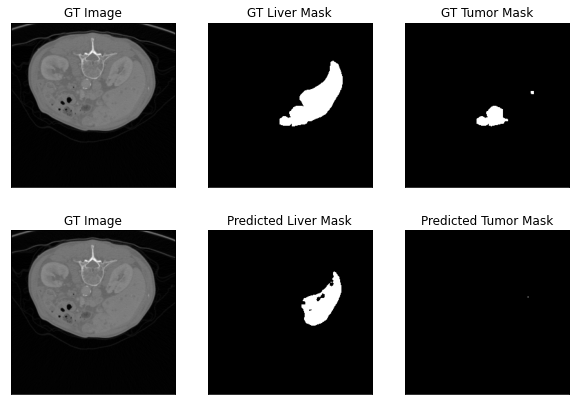

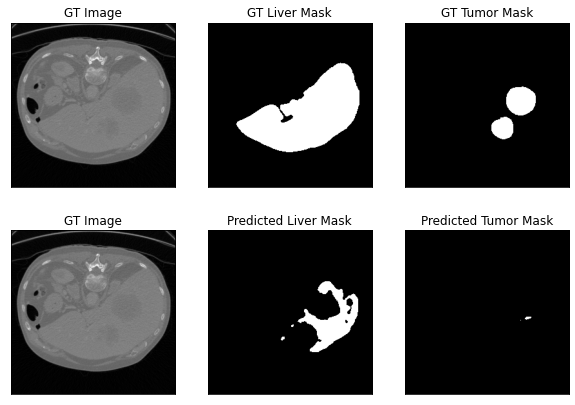

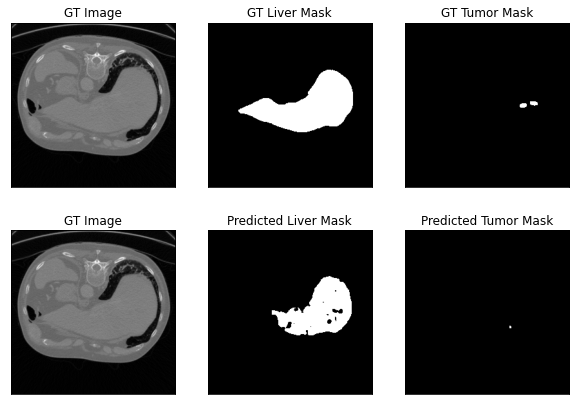

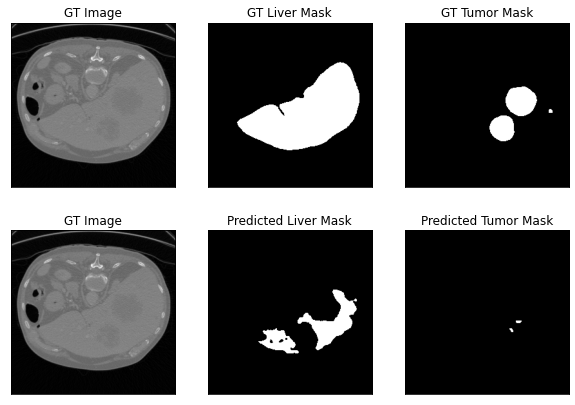

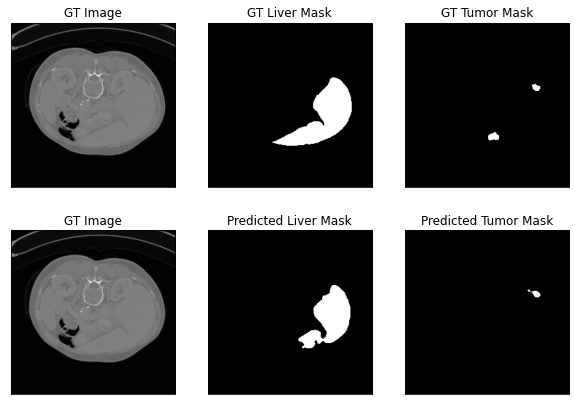

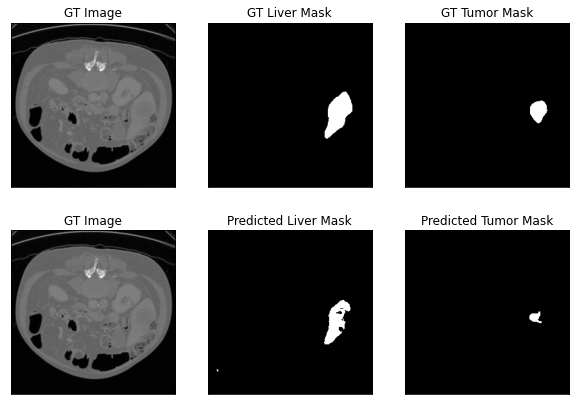

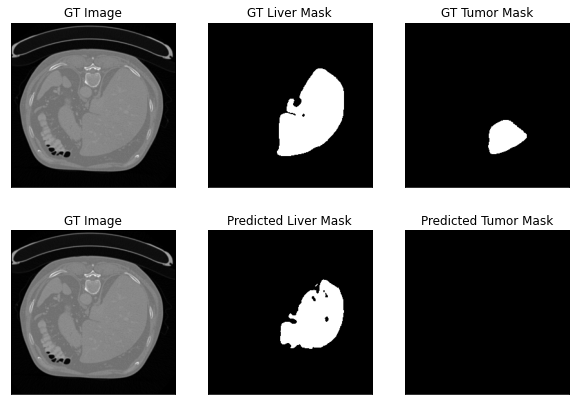

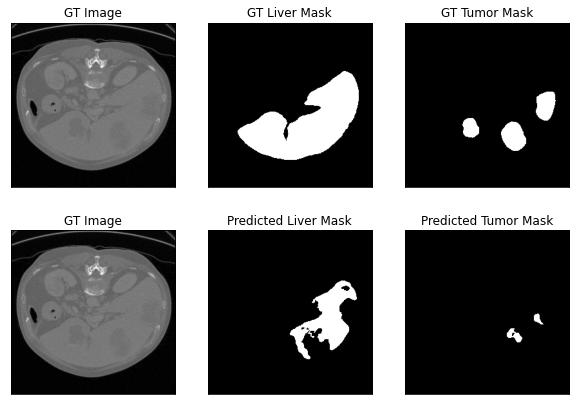

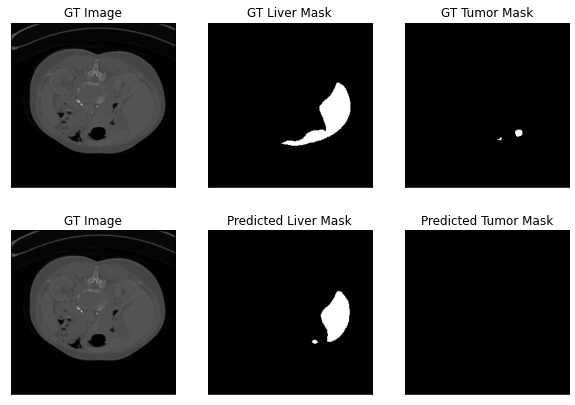

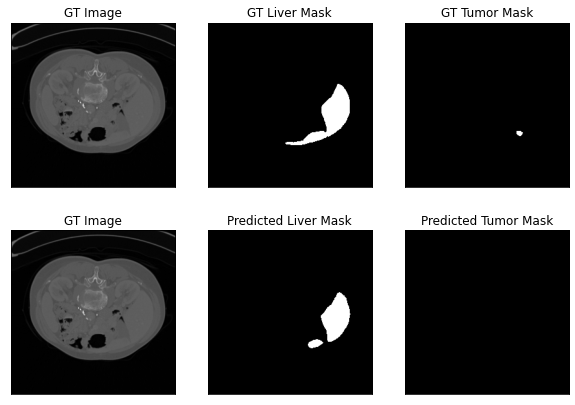

In [409]:
for _ in range(10):
    sample = next(iter(test_loader))
    # sample = test_dataset[random.randint(0, len(test_dataset))]
    # print(sample[0].shape, sample[1].shape)
    preds = sig(model(sample[0].to(device))).round()

    plt.figure(figsize=(10,7))

    plt.subplot(2,3,1)
    plt.imshow(sample[0][0,0,:,:], cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.title("GT Image")
    plt.subplot(2,3,2)
    plt.imshow(sample[1][0,0,:,:], cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.title("GT Liver Mask")
    plt.subplot(2,3,3)
    plt.imshow(sample[1][0,1,:,:], cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.title("GT Tumor Mask")
    # plt.imshow(pred[])

    plt.subplot(2,3,4)
    plt.imshow(sample[0][0,0,:,:], cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.title("GT Image")
    plt.subplot(2,3,5)
    plt.imshow(preds[0,0,:,:].detach().cpu().numpy(), cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.title("Predicted Liver Mask")
    plt.subplot(2,3,6)
    plt.imshow(preds[0,1,:,:].detach().cpu().numpy(), cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.title("Predicted Tumor Mask")
    plt.show()

## Overall

In [8]:
for model_name in all_model_names:
    backbone = backbones[model_name.split("_")[3]]
    all_chckpoints = [i[:-4] for i in sorted(os.listdir(f"{model_path}{model_name}"))]
    checkpoint = f"""{["_".join(i) for i in sorted([i.split('_') for i in all_chckpoints], key=lambda x: int(x[-4]))][-1]}.pth"""
    model = load_model(backbone=backbone, device=device, model_dir= model_dir, model_name=model_name, checkpoint = checkpoint, num_classes=num_classes)
    
    print(f"Testing {model_name} with {checkpoint} ......")
    print(" ")
    df_dict = init_test(model = model, device = device, test_loader = test_loader, model_name=model_name)
    print(df_dict)
    print(" ")
    save_results(df_dict)
    # df = pd.DataFrame(df_dict)
    # print(df)

Testing unet_dice_loss_mobilenet_v2_1.0_1.0 with model_epoch_47_val_dice_0.02947198785841465.pth ......
 


100%|██████████| 3586/3586 [00:37<00:00, 94.86it/s] 


{'model_name': ['unet_dice_loss_mobilenet_v2_1.0_1.0'], 'Dice Score': [0.10025651615821511], 'Jackard': [0.09924301938909562], 'Dice Score cls0': [0.24467579009020088], 'Dice Score cls1': [0.1002565018703932], 'Test Jackard cls1': [0.20648418291146545], 'Test Jackard cls2': [0.0992430042318759], 'Test Accuracy': [0.9713031281589863], 'Test Accuracy cls1': [0.9475691327819994], 'Test Accuracy cls2': [0.9950335152110639]}
 
Testing unet_dice_loss_mobilenet_v2_1.0_5.0 with model_epoch_48_val_dice_0.029560843482613564.pth ......
 


100%|██████████| 3586/3586 [00:41<00:00, 86.69it/s] 


{'model_name': ['unet_dice_loss_mobilenet_v2_1.0_5.0'], 'Dice Score': [0.7038216790339166], 'Jackard': [0.702371200501952], 'Dice Score cls0': [0.281765753051398], 'Dice Score cls1': [0.7038217757743673], 'Test Jackard cls1': [0.2427360765582467], 'Test Jackard cls2': [0.7023709236593857], 'Test Accuracy': [0.9823309860612451], 'Test Accuracy cls1': [0.9689419901178193], 'Test Accuracy cls2': [0.9957148758845161]}
 
Testing unet_BCE_loss_mobilenet_v2_1.0_5.0 with model_epoch_16_val_dice_0.029491551220417023.pth ......
 


100%|██████████| 3586/3586 [00:39<00:00, 90.64it/s] 


{'model_name': ['unet_BCE_loss_mobilenet_v2_1.0_5.0'], 'Dice Score': [0.7739312958597672], 'Jackard': [0.759734647871061], 'Dice Score cls0': [0.4288609779657504], 'Dice Score cls1': [0.7739311440161398], 'Test Jackard cls1': [0.3906884531426746], 'Test Jackard cls2': [0.7597348257696775], 'Test Accuracy': [0.9827406330608617], 'Test Accuracy cls1': [0.9701393412533115], 'Test Accuracy cls2': [0.9953378399722881]}
 
Testing unet_dice_loss_resnet101_1.0_5.0 with model_epoch_42_val_dice_0.029684992507100105.pth ......
 


100%|██████████| 3586/3586 [00:59<00:00, 60.52it/s]


{'model_name': ['unet_dice_loss_resnet101_1.0_5.0'], 'Dice Score': [0.6391840528923243], 'Jackard': [0.6337871562151423], 'Dice Score cls0': [0.18452636709397038], 'Dice Score cls1': [0.6391842376331328], 'Test Jackard cls1': [0.14108082524833737], 'Test Jackard cls2': [0.6337873068403043], 'Test Accuracy': [0.9468610841205382], 'Test Accuracy cls1': [0.8981994186375837], 'Test Accuracy cls2': [0.9955216602978597]}
 
Testing unet_dicebce_loss_mobilenet_v2_1.0_5.0 with model_epoch_45_val_dice_0.02958994172513485.pth ......
 


100%|██████████| 3586/3586 [00:39<00:00, 91.78it/s]

{'model_name': ['unet_dicebce_loss_mobilenet_v2_1.0_5.0'], 'Dice Score': [0.8105024177138525], 'Jackard': [0.8004905415591885], 'Dice Score cls0': [0.29332694453662556], 'Dice Score cls1': [0.8105023429170244], 'Test Jackard cls1': [0.25654295506267466], 'Test Jackard cls2': [0.8004907225487519], 'Test Accuracy': [0.9809442999904141], 'Test Accuracy cls1': [0.966187544661531], 'Test Accuracy cls2': [0.9956994213608478]}
 


In [11]:
df_dict

{'model_name': ['unet_dicebce_loss_mobilenet_v2_1.0_5.0'],
 'Dice Score': [0.8105024177138525],
 'Jackard': [0.8004905415591885],
 'Dice Score cls0': [0.29332694453662556],
 'Dice Score cls1': [0.8105023429170244],
 'Test Jackard cls1': [0.25654295506267466],
 'Test Jackard cls2': [0.8004907225487519],
 'Test Accuracy': [0.9809442999904141],
 'Test Accuracy cls1': [0.966187544661531],
 'Test Accuracy cls2': [0.9956994213608478]}

In [10]:

# df_dict = {'checkpoint': [checkpoint], 
#             'Dice Score': [test_dice_score.cpu().numpy()/len(test_loader)], 
#             'Jackard': [test_jaccard_score.cpu().numpy()/len(test_loader)], 
#             "Dice Score cls0":[test_dice_score_cls1/len(test_loader)], 
#             "Dice Score cls1":[test_dice_score_cls2/len(test_loader)], 
#             'Test Jackard cls1': [test_jaccard_score_cls1/len(test_loader)], 
#             'Test Jackard cls2': [test_jaccard_score_cls2/len(test_loader)],
#             'Test Accuracy': [test_accuracy.cpu().numpy()/len(test_loader)],
#             'Test Accuracy cls1': [test_accuracy_cls1.cpu().numpy()/len(test_loader)],
#             'Test Accuracy cls2': [test_accuracy_cls2.cpu().numpy()/len(test_loader)]
#             }